<a href="https://colab.research.google.com/github/Adr1an11/Pneumonia-detection/blob/colab_branch/pneunomia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneunomia detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Step: Reading pictures in

In [2]:
# lehetséges modellek amik jók lehetnek: resnet50(ezzel csináltam a betűfelismerést), sequential(ez vol kaggle-on), svm(ez volt amm órán),

ütemterv:
- Rövid helyzetjelentés emailben (sikerült-e a haladni, mi a helyzet), minden héten kedden (akkor is, ha épp nem volt rá idő vagy energia)
- Április 10-ig: kész és dokumentált feltáró adatelemzés (EDA)
- Április 19-ig: teljes, kész irodalomkutatás - adatbányászat + EDA alapok + gépi tanulás és algoritmusok melyeket használni fogsz
- Május 7-ig: elkészült gépi tanulási modellek és az eredmények értékelése
- Május 13-ig: Benyújtásra kész, általad véglegesnek ítélt dokumentáció elküldése nekem (az osztályzatnál figyelembe lesz véve az állapota)
- Május 24-ig: Az egyetemnek benyújtott dokumentáció (végső értékeléshez)
- Teljesen kész prezentáció a prezentáció előtt egy héttel legalább

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

'''from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential'''

import cv2
import tqdm
import glob

#resnet importalasa
'''from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions'''

'from keras.applications.resnet50 import ResNet50\nfrom keras.applications.resnet50 import preprocess_input, decode_predictions'

In [4]:
# beolvasas
'''train_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("archive/chest_xray/train/NORMAL/*.jpeg"), desc = "Betoltes") ]
train_pneunomia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("archive/chest_xray/train/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]'''

'train_normal = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("archive/chest_xray/train/NORMAL/*.jpeg"), desc = "Betoltes") ]\ntrain_pneunomia = [cv2.imread(file) for file in tqdm.tqdm(glob.glob("archive/chest_xray/train/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]'

In [5]:
memmap_file = "/content/images_memmap.dat"
image_paths = glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/*.jpeg")
image_paths2 = glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/*.jpeg")
#shape = (len(image_paths), 128, 128, 3)  # (db, magasság, szélesség, csatornák)

images_memmap = np.memmap(memmap_file, dtype=np.uint8, mode="w+", shape=shape)

for i, file in enumerate(tqdm.tqdm(image_paths, desc="Betöltés")):
    img = cv2.resize(cv2.imread(file), (128, 128))
    images_memmap[i] = img  # Az adatok lemezre kerülnek, nem RAM-ba

del images_memmap  # Felszabadítja a RAM-ot

# Később így töltheted be a memmap fájlt újra anélkül, hogy a RAM-ot terhelnéd:
images = np.memmap(memmap_file, dtype=np.uint8, mode="r", shape=shape)


Betöltés: 100%|██████████| 1341/1341 [01:06<00:00, 20.03it/s]


In [ ]:
'''train_normal = [load_image(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/NORMAL/*.jpeg"), desc = "Betoltes") ]
train_pneunomia = [load_image(file) for file in tqdm.tqdm(glob.glob("/content/drive/MyDrive/Colab Notebooks/tudogyulladas/windows/train/PNEUMONIA/*.jpeg"), desc = "Betoltes") ]'''

Betoltes:  13%|█▎        | 516/3895 [01:01<00:53, 63.68it/s]

[]

In [7]:
len(train_normal)
len(train_pneunomia)

1341

# Feltáró adatelemzés (Exploratory Data Analysis)

In [ ]:
# class imbalance:
#making it a dictionary
classes = {'Normal':len(train_normal), 'Pneumonia':len(train_pneunomia) }
plt.figure(figsize=(10,6))
plt.title('Number of images by class')
plt.xlabel('Class name')
plt.ylabel('Number of pictures')
sns.barplot(classes,width=0.5)



Konklúzió: Látható, hogy fetőzött tüdőről lényegesen több kép van mint normálisról, ezáltal előfordulhat egyenlőtlenség

In [8]:
# checking the image sizes
def get_dimensions(dataset):
    dimensions = pd.DataFrame(columns=['height', 'width'])
    for i in range(0, len(dataset)):
        im = dataset[i]
        array = np.array(im)
        h,w,d = array.shape
        dimensions.loc[len(dimensions)] = [h,w]
    return dimensions

In [9]:
normal_df = get_dimensions(train_normal)

<Axes: title={'center': 'Distribution of image sizes for normal lungs'}, xlabel='height', ylabel='width'>

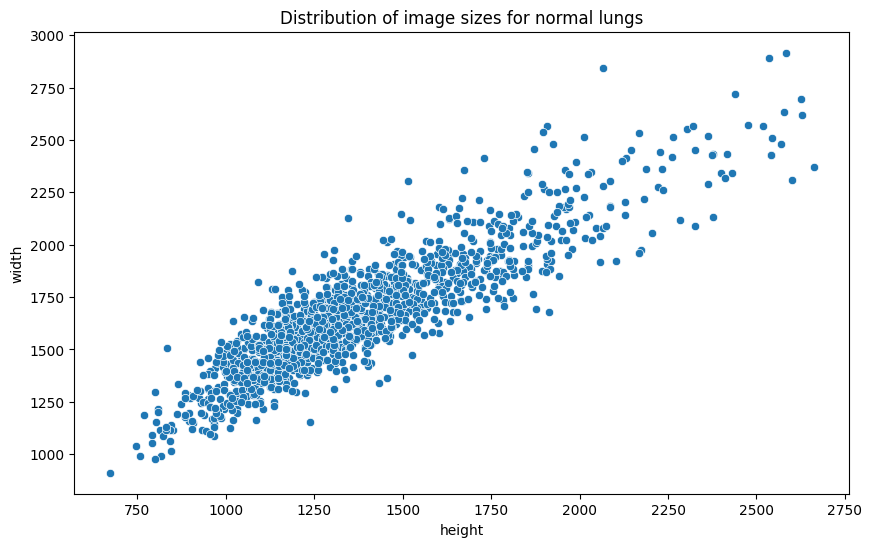

In [10]:
# plotting image sizes
plt.figure(figsize=(10,6))
plt.title('Distribution of image sizes for normal lungs')
sns.scatterplot(data=normal_df, x='height', y='width')

In [ ]:
pneumonia_df = get_dimensions(train_pneunomia)

<Axes: title={'center': 'Distribution of image sizes for infected lungs'}, xlabel='height', ylabel='width'>

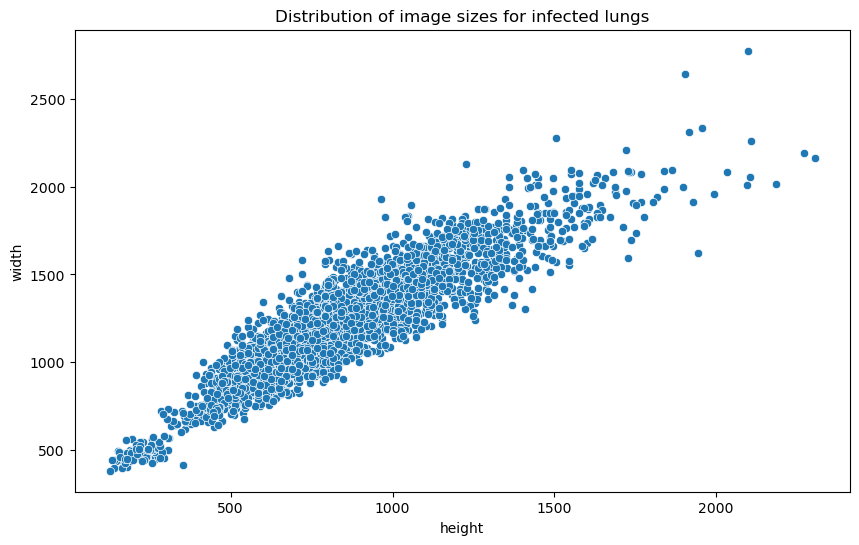

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Distribution of image sizes for infected lungs')
sns.scatterplot(data=pneumonia_df, x='height', y='width')

Konklúzió: A képek egyáltalán nem egységesek, nagyon sokféle méretben vannak jelen az adatbázisban

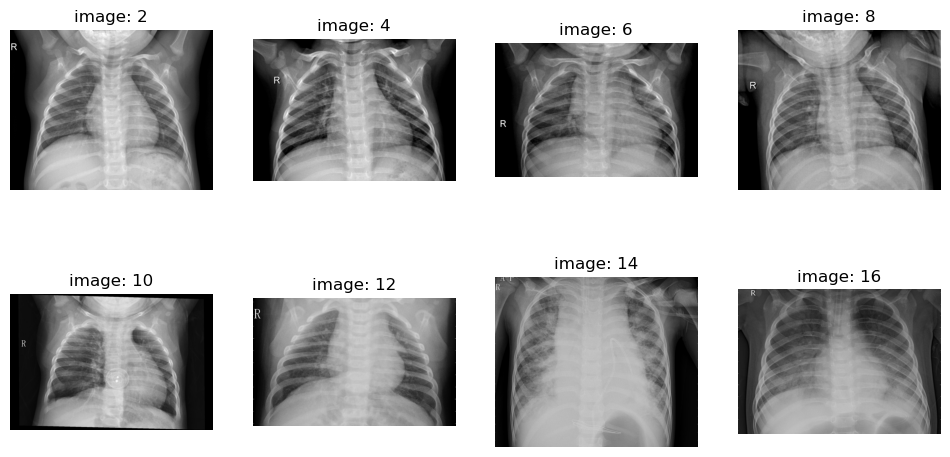

In [ ]:
# Showing examples from each class
plt.figure(figsize=(12,6))
for i in range(1, 9):
    plt.subplot(2, 4, i) #sor,oszlop,melyiknel legyen epp
    if i < 5:
        plt.imshow(train_normal[i*2])
        plt.title(f"image: {i*2}")
        plt.axis('off')
    else:
        plt.imshow(train_pneunomia[i*2])
        plt.axis('off')
        plt.title(f"image: {i*2}")


In [ ]:
#resizing the images for faster calculations with keeping the aspect ratio
'''def resize_with_keeping_ratio(images):
    resized_images = []
    for image in images:
        # Get the original dimensions
        (h, w) = image.shape[:2]

        # Desired width
        new_width = 256

        # Calculate the aspect ratio
        aspect_ratio = h / w
        new_height = int(new_width * aspect_ratio)

        # Resize the image
        resized_image = cv2.resize(image, (new_width, new_height))
        resized_images.append(resized_image)
    return resized_images'''
#hatekonyabb
def resize_with_keeping_ratio(images, new_width=256):
    return [cv2.resize(img, (new_width, int(new_width * img.shape[0] / img.shape[1]))) for img in images]

In [ ]:
resized_normal = resize_with_keeping_ratio(train_normal)
resized_pneumonia = resize_with_keeping_ratio(train_pneunomia)

In [ ]:
'''import os
#i would like to save these resized image so that i can read these in for further work and use these for training the model
# currently im not sure if this is necessary so i come back later to that problem
def save_images(images, origin_path, output_folder) :
    #Az eredeti fájlnevek listája
    original_filenames = [os.path.basename(path) for path in origin_path]

    # A célmappa létrehozása, ha nem létezik
    os.makedirs(output_folder, exist_ok=True)

    # Mentés az eredeti fájlnevekkel
    for i in range(len(images)):
        save_path = os.path.join(output_folder, original_filenames[i])
        cv2.imwrite(save_path, images[i])
        print(f"Mentve: {save_path}")


# glob saves the filenames as a list
normal = glob.glob("archive/chest_xray/train/NORMAL/*.jpeg")
pneumonia = glob.glob("archive/chest_xray/train/PNEUMONIA/*.jpeg")'''

In [ ]:
# Images as matrix
from tensorflow.keras.preprocessing import image
img = image.img_to_array(resized_normal[0])

In [ ]:
def img_to_np(images):
    image_matrix = []
    for im in images:
        matrix = image.img_to_array(im)
        matrix = [matrix.ravel()]
        image_matrix.append(matrix)
    return image_matrix
# nem hasznaljuk a ravelt
'''def img_to_np(images):
    image_matrix = [image.img_to_array(im).ravel() for im in images]  # Lapított képek listája
    return np.array(image_matrix)  # NumPy tömbbé alakítás'''

In [ ]:
normal_array = img_to_np(resized_normal)
pneumonia_array = img_to_np(resized_pneumonia)

In [ ]:
# how does the average image looks like
'''def mean_img(matrix_array, title):
    mean = np.mean(matrix_array,axis=0)
    plt.imshow(mean, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean'''


def mean_img(matrix_array, title):
    mean = np.mean(matrix_array, axis=0).reshape((image_size, image_size))  # Visszaalakítás képformátumba
    plt.imshow(mean, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean

In [ ]:
nm = mean_img(normal_array,"normalisvagy?")